In [13]:
import os, sys, pymp
sys.path.append(os.path.abspath('../utils'))

import numpy as np # type: ignore
import scipy.io as sio
import matplotlib.pyplot as plt # type: ignore
import matplotlib.colors as mcolors # type: ignore
import analytic_eqs as cases # type: ignore
import surd as surd # type: ignore
from matplotlib.colors import LinearSegmentedColormap
import it_tools as it # type: ignore
np.random.seed(10)

# Configure matplotlib to use LaTeX for text rendering and set font size
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

my_colors = {}
my_colors['redundant'] = mcolors.to_rgb('#003049')
my_colors['unique'] = mcolors.to_rgb('#d62828')
my_colors['synergistic'] = mcolors.to_rgb('#f77f00')
my_colors['red'] = mcolors.to_rgb('#d62828')
my_colors['green'] = mcolors.to_rgb('#6ca13b')
my_gray = mcolors.to_rgb('#000000')
my_gray = tuple([c + (1-c) * 0.8 for c in my_gray])
my_colors['gray'] = my_gray

for key, value in my_colors.items():
    rgb = mcolors.to_rgb(value)
    my_colors[key] = tuple([c + (1-c) * 0.4 for c in rgb])

In [14]:
data = sio.loadmat('../data/tbl_inner_outer.mat')
X = data['u']
time_plus = data['t']
nvars = X.shape[0]
nbins = 25 
max_lag = 100

In [15]:
max_abs = np.percentile(X, 99.9)
max_abs = np.floor(max_abs)
bin_width = 2 * max_abs / (nbins-1)  # Calculate the bin width

bins_list = []
for i in range(X.shape[0]):
    if i == 0:
        lower_limit = np.percentile(X[i, :], 0.01)
        upper_limit = np.percentile(X[i, :], 99.99)
    else:
        lower_limit = np.percentile(X[i, :], 0.001)
        upper_limit = np.percentile(X[i, :], 98.5)
    bin_width = (upper_limit - lower_limit) / (nbins - 1)
    bins = np.linspace(lower_limit, upper_limit + bin_width, nbins + 1)
    bins_list.append(bins)

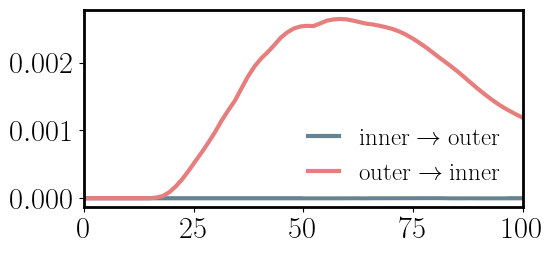

In [16]:
# Select delta T
nlags_range = range(1, max_lag, 1)
num_lags = len(nlags_range)

# Initialize a shared array with dimensions [nvars, nlags]
unique_lag = pymp.shared.array((nvars, num_lags), dtype=np.float64)
synergy_lag = pymp.shared.array((nvars, num_lags), dtype=np.float64)
self_unique_lag = pymp.shared.array((nvars, num_lags), dtype=np.float64)

# === Causality analysis across lags ===
with pymp.Parallel(2) as par:
    for i in par.range(nvars):
        for n_idx, nlag in enumerate(nlags_range):
            # Prepare lagged joint data
            Y = np.vstack([X[i, nlag:], X[:, :-nlag]])

            # Compute joint histogram
            hist, _ = np.histogramdd(Y.T, bins=[bins_list[i], bins_list[0], bins_list[1]])

            # Compute SURD decomposition
            I_R, I_S, MI, info_leak, *_ = surd.surd_states(hist)
            H = it.entropy_nvars(hist, (0,))  # Entropy of target

            # Unique causality from all other sources
            single_keys = [k for k in I_R if len(k) == 1 and k != (i+1,)]
            unique_lag[i, n_idx] = sum(I_R[k] for k in single_keys) / H

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(time_plus[:max_lag-1], unique_lag[0, :], color=my_colors['redundant'], linewidth=3, label='$\\rm inner \\rightarrow outer$')
ax.plot(time_plus[:max_lag-1], unique_lag[1, :], color=my_colors['unique'], linewidth=3, label='$\\rm outer \\rightarrow inner$')
ax.set_xlim(0, max_lag)
for side in ['top', 'bottom', 'left', 'right']:
    ax.spines[side].set_linewidth(2)

leg = ax.legend(loc='best', edgecolor='white', handlelength=1.25, fontsize=18)
leg.get_frame().set_alpha(None)
leg.get_frame().set_facecolor((1, 1, 1, 1))

plt.tight_layout()
plt.show()

In [17]:
# === Find max lag index for cross causality (outer → inner) ===
# nlag = 39
nlag = unique_lag[1, :].argmax()
print(f'Maximum cross-induced causality at lag index {nlag}, which is equivalent to {time_plus[nlag][0]:.2f} time plus units')

Maximum cross-induced causality at lag index 39, which is equivalent to 58.28 time plus units


INFORMATION FLUX FOR SIGNAL 1
    Redundant (R):
        (1, 2)      : 0.0548
    Unique (U):
        (1,)        : 0.7390
        (2,)        : 0.0000
    Synergystic (S):
        (1, 2)      : 0.2063
    Information Leak: 99.78%


INFORMATION FLUX FOR SIGNAL 2
    Redundant (R):
        (1, 2)      : 0.2514
    Unique (U):
        (1,)        : 0.4576
        (2,)        : 0.0403
    Synergystic (S):
        (1, 2)      : 0.2507
    Information Leak: 99.42%




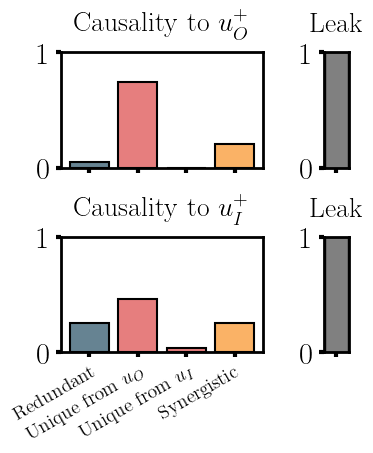

In [18]:
Rd_results, Sy_results, mi_results, info_leak_results = {}, {}, {}, {}
rd_states_results, u_states_results, sy_states_results = {}, {}, {}
    
fig, axs = plt.subplots(nvars, 2, figsize=(7, 2.5 * nvars), gridspec_kw={'width_ratios': [35, 1]})

for i in range(nvars):
    print(f'INFORMATION FLUX FOR SIGNAL {i+1}')

    # Stack the target and sources
    Y = np.vstack([X[i, nlag:], X[:, :-nlag]])

    # Estimate joint histogram
    hist, bins = np.histogramdd(Y.T, bins=[bins_list[i], bins_list[0], bins_list[1]])

    # Compute SURD contributions
    Rd, Sy, mi, info_leak, rd_states, u_states, sy_states = surd.surd_states(hist)

    # Print results
    surd.nice_print(Rd, Sy, mi, info_leak)

    # Plot SURD
    _ = surd.plot(Rd, Sy, info_leak, axs[i,:], nvars, threshold=-0.01)
    axs[i,0].set_title(f'${{\\Delta I}}_{{(\\cdot) \\rightarrow {i+1}}} / I \\left(Q_{i+1}^+ ; \\mathrm{{\\mathbf{{Q}}}} \\right)$',pad=12)
    axs[i,1].set_title(f'$\\frac{{{{\\Delta I}}_{{\\mathrm{{leak}} \\rightarrow {i+1}}}}}{{H \\left(Q_{i+1}^+ \\right)}}$',pad=20)
    axs[i,0].set_xticklabels(axs[i,0].get_xticklabels(), fontsize=18, rotation = 60, ha = 'right', rotation_mode='anchor')
    axs[i,0].set_yticks([0,1])
    axs[i,0].set_ylim([0,1])
    axs[i, 0].set_box_aspect(1/1.75)

    # Show the results
    for j in range(0,nvars-1):
        axs[j,0].set_xticklabels('')

    # Store results
    Rd_results[i + 1] = Rd
    Sy_results[i + 1] = Sy
    mi_results[i + 1] = mi
    info_leak_results[i + 1] = info_leak
    rd_states_results[i + 1] = rd_states
    u_states_results[i + 1] = u_states
    sy_states_results[i + 1] = sy_states

axs[0, 0].set_title(f'${{\\Delta I}}_{{(\\cdot) \\rightarrow O}} / I \\left(u_O^+ ; \\mathrm{{\\mathbf{{u}}}} \\right)$', pad=15)
axs[0, 1].set_title(f'$\\frac{{{{\\Delta I}}_{{\\mathrm{{leak}} \\rightarrow O}}}}{{H \\left(u_O^+\\right)}}$', pad=20)
axs[1, 0].set_title(f'${{\\Delta I}}_{{(\\cdot) \\rightarrow I}} / I \\left(u_I^+ ; \\mathrm{{\\mathbf{{u}}}} \\right)$', pad=15)
axs[1, 1].set_title(f'$\\frac{{{{\\Delta I}}_{{\\mathrm{{leak}} \\rightarrow I}}}}{{H \\left(u_I^+\\right)}}$', pad=20)
# axs[1, 0].set_xticklabels([f'$\\rm ROI$', f'$\\rm UO$', f'$\\rm UI$', f'$\\rm SOI$'], fontsize=16, rotation=0, ha='center', rotation_mode='anchor')
axs[0, 0].set_title(f'${{\\rm Causality\\,\\,to\\,\\,}} u_O^+$', fontsize=20, pad=15)
axs[0, 1].set_title(f'$\\rm Leak$', pad=15, fontsize=20)
axs[1, 0].set_title(f'${{\\rm Causality\\,\\,to\\,\\,}} u_I^+$', fontsize=20, pad=15)
axs[1, 1].set_title(f'$\\rm Leak$', pad=15, fontsize=20)
axs[1, 0].set_xticklabels([f'$\\rm Redundant$', f'${{\\rm Unique\\,\\,from\\,\\,}} u_O$', f'${{\\rm Unique\\,\\,from\\,\\,}} u_I$', f'$\\rm Synergistic$'], fontsize=14, rotation=30, ha='right', rotation_mode='anchor')

plt.tight_layout(w_pad=-8, h_pad=0.3)
plt.show()

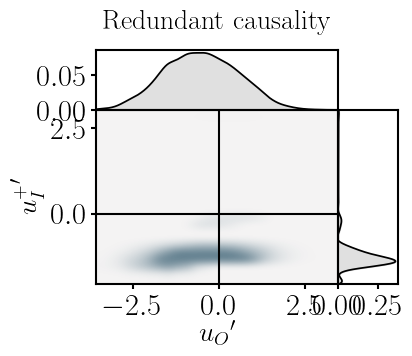

In [19]:
target = 2
source = 1

data = rd_states_results[target][(1, 2)] / Rd_results[target][(1, 2)]
data = np.maximum(data, 0)
pos = np.argmax(data.sum(axis=(0,1)))

colors = [my_gray, '#F5F4F4', my_colors['redundant']]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

fig, ax_main, _, _ = surd.plot_states(
                  data=data[:,:,pos], bins=bins,
                  target=target, source=source,
                  save_path=os.path.join('../figures', 'tbl_R12_states.pdf'),
                  title=r'$\rm{Redundant}$  $\rm{causality}$',
                  xlabel=f'${{u_O}}\'$', ylabel=f'${{u_I^+}}\'$',
                  vmax=0.5*np.max(data), vmin=-0.5*np.max(data), 
                  cmap=custom_cmap, norm=False)

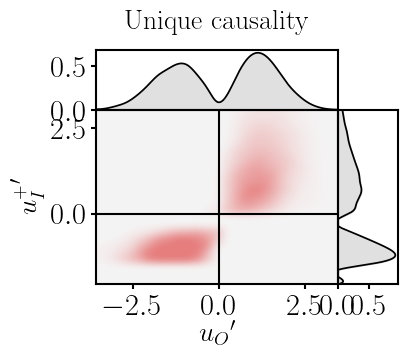

In [20]:
target = 2
source = 1

data = u_states_results[target][(source,)] / Rd_results[target][(source,)]
data = np.maximum(data, 0)

colors = [my_colors['redundant'], '#F5F4F4', my_colors['unique']]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

fig, ax_main, _, _ = surd.plot_states(
                  data=data, bins=bins,
                  target=target, source=source,
                  save_path=os.path.join('../figures', f'tbl_U{source}_states.pdf'),
                  title=r'$\rm{Unique}$  $\rm{causality}$',
                  xlabel=f'${{u_O}}\'$', ylabel=f'${{u_I^+}}\'$',
                  vmax=0.5*np.max(data), vmin=-0.5*np.max(data), 
                  cmap=custom_cmap, norm=False)

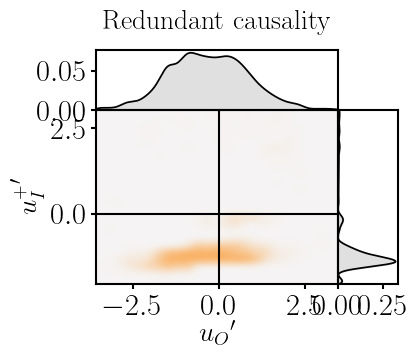

In [21]:
target = 2
source = 1

data = sy_states_results[target][(1, 2)] / Sy_results[target][(1, 2)]
data = np.maximum(data, 0)
pos = np.argmax(data.sum(axis=(0,1)))

colors = [my_colors['unique'], '#F5F4F4', my_colors['synergistic']]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

fig, ax_main, _, _ = surd.plot_states(
                  data=data[:,:,pos], bins=bins,
                  target=target, source=source,
                  save_path=os.path.join('../figures', 'tbl_S12_states.pdf'),
                  title=r'$\rm{Redundant}$  $\rm{causality}$',
                  xlabel=f'${{u_O}}\'$', ylabel=f'${{u_I^+}}\'$',
                  vmax=0.5*np.max(data), vmin=-0.5*np.max(data), 
                  cmap=custom_cmap, norm=False)